# Variational Quantum Eigensolvers

In this notebook, we will use a quantum circuit ansatz to find the gound state of the transverse field Ising model for N sites:

$$H = -\sum_{i=1}^{N-1}\sigma^{z}_{i}\sigma^{z}_{i+1} - h\sum_{i=1}^{N}\sigma^{x}_{i}$$

where $\sigma^{x}$ and $\sigma^{z}$ are pauli matrices.

In [10]:
import numpy as np
import time
import pennylane as qml
from ttn import ttn_circuit
from mera import mera_circuit, get_num_mera_gates
from hea import hea_circuit
from hamiltonians import tfi_chain
import matplotlib.pyplot as plt

We'll first construct the transverse field Ising model Hamiltonian at the critical point

In [11]:
periodic=True
num_qubits = 8
h = 1.0
H = tfi_chain(num_qubits, h, periodic=periodic)
#exact_E0 = 1.0 - 1.0/np.sin(np.pi/(2.0 * (2.0 * num_qubits + 1.0))) # for open bc
exact_E0 = -1.281457723870752 #hardcoded for periodic and N = 8

Next, we'll construct our three ansatze to compare with each other, starting with the tree tensor network:

In [12]:

# The simulator.
ttn_dev = qml.device('default.qubit', wires=num_qubits)

# The TTN circuit.
ttn_ansatz = ttn_circuit(num_qubits)

# The circuit for computing the expectation value of H.
ttn_cost_fn = qml.ExpvalCost(ttn_ansatz, H, ttn_dev, optimize=True)

num_params_per_gate = 15                                 # The number of parameters in each two-qubit gate.
num_gates           = num_qubits- 1                      # The number of two-qubit gates in the TTN.
num_params          = num_params_per_gate * num_gates    # The total number of parameters in the TTN.

# Initialize the parameters.
np.random.seed(1)
ttn_params0 = np.pi*(np.random.rand(num_params) - 1.0)


Then the MERA:

In [13]:
# The simulator.
mera_dev = qml.device('default.qubit', wires=num_qubits)

# The MERA circuit.
mera_ansatz = mera_circuit(num_qubits, periodic=periodic)

# The circuit for computing the expectation value of H.
mera_cost_fn = qml.ExpvalCost(mera_ansatz, H, mera_dev, optimize=True)

num_params_per_gate = 15                                                    # The number of parameters in each two-qubit gate.
num_gates           = get_num_mera_gates(num_qubits, periodic=periodic)     # The number of two-qubit gates in the MERA.
num_params          = num_params_per_gate * num_gates                       # The total number of parameters in the MERA.

# Initialize the parameters.
np.random.seed(1)
mera_params0 = np.pi*(np.random.rand(num_params) - 1.0)

And finally the HEA. We'll do a Linear depth ansatz here:

In [14]:
# The simulator.
hea_dev = qml.device('default.qubit', wires=num_qubits)

# The HEA circuit.
hea_ansatz = hea_circuit(num_qubits)

# The circuit for computing the expectation value of H.
hea_cost_fn = qml.ExpvalCost(hea_ansatz, H, hea_dev, optimize=True)

hea_depth           = num_qubits                 # how many times we'll repeat the circuit
num_gates           = hea_depth * num_qubits     # The number of rotation gates in the HEA.
num_params          = 3*hea_depth*num_qubits     # The total number of parameters in the HEA.

# Initialize the parameters.
np.random.seed(1)
hea_params0 = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_params, 3))

Now we will perform the optimization via gradient descent

In [15]:
# Optimizer parameters.
rtol     = 1e-5
atol     = 1e-9
maxiter  = 100                                                                                          
stepsize = 0.05   
print_results = True                                                                                                        
opt =  qml.GradientDescentOptimizer(stepsize=stepsize)  

In [16]:
ansatz_list = ["HEA", "TTN", "MERA"]
param_list = [hea_params0, ttn_params0, mera_params0]
cost_fn_list = [hea_cost_fn, ttn_cost_fn, mera_cost_fn]

Now we'll Perform VQE on each of these ansatze with the gradient descent optimizer.

In [17]:
# Perform VQE.
times_opts = []
objs_opts  = []
for (ansatz_name, params0, cost_fn) in zip(ansatz_list, param_list, cost_fn_list):
    times = []
    objs  = []

    print(f"Ansatz {ansatz_name}")
    params   = np.copy(params0)
    prev_obj = 0.0
    for step in range(maxiter):
        start = time.time()
        params, obj  = opt.step_and_cost(cost_fn, params)
        end   = time.time()

        times.append(end - start)
        objs.append(obj)

        diff_obj     = np.abs(prev_obj - obj)
        rel_obj      = diff_obj/np.abs(prev_obj + 1e-15)

        prev_obj = obj

        if print_results:
            print(f"Step {step+1}, <H>/L = {obj/num_qubits}")

        if rel_obj < rtol or diff_obj < atol:
            if print_results:
                print(f"Took {step+1} steps.")
                print(f"diff_obj = {diff_obj}, rel_obj = {rel_obj}.")
            break

    times_opts.append(times)
    objs_opts.append(objs)

Ansatz HEA
Step 1, <H>/L = -0.037572918170535256
Step 2, <H>/L = -0.15809122606366485
Step 3, <H>/L = -0.2680137056915365
Step 4, <H>/L = -0.3625103992446044
Step 5, <H>/L = -0.4428750252918934
Step 6, <H>/L = -0.5120580943498807
Step 7, <H>/L = -0.5723884582108916
Step 8, <H>/L = -0.6254872103871273
Step 9, <H>/L = -0.6725722165094424
Step 10, <H>/L = -0.7145524523149163
Step 11, <H>/L = -0.7521041176956156
Step 12, <H>/L = -0.7857714766902307
Step 13, <H>/L = -0.8160372748597089
Step 14, <H>/L = -0.8433497356676329
Step 15, <H>/L = -0.8681218076081
Step 16, <H>/L = -0.890718792462947
Step 17, <H>/L = -0.9114460028510956
Step 18, <H>/L = -0.9305438604815996
Step 19, <H>/L = -0.9481928987203825
Step 20, <H>/L = -0.9645265836012593
Step 21, <H>/L = -0.9796473767625753
Step 22, <H>/L = -0.9936414666392983
Step 23, <H>/L = -1.0065892848582187
Step 24, <H>/L = -1.0185710467746134
Step 25, <H>/L = -1.0296681506278489
Step 26, <H>/L = -1.0399619847453836
Step 27, <H>/L = -1.049531662349748
S

Step 63, <H>/L = -1.258266566716258
Step 64, <H>/L = -1.2583258413380762
Step 65, <H>/L = -1.2583799762758785
Step 66, <H>/L = -1.2584294606258328
Step 67, <H>/L = -1.2584747344616933
Step 68, <H>/L = -1.2585161941731458
Step 69, <H>/L = -1.258554197151056
Step 70, <H>/L = -1.2585890659114207
Step 71, <H>/L = -1.2586210917350258
Step 72, <H>/L = -1.2586505378877293
Step 73, <H>/L = -1.2586776424763007
Step 74, <H>/L = -1.2587026209865182
Step 75, <H>/L = -1.2587256685432666
Step 76, <H>/L = -1.2587469619268394
Step 77, <H>/L = -1.2587666613746407
Step 78, <H>/L = -1.2587849121936903
Step 79, <H>/L = -1.2588018462057746
Step 80, <H>/L = -1.258817583044253
Step 81, <H>/L = -1.2588322313192286
Step 82, <H>/L = -1.258845889665439
Step 83, <H>/L = -1.258858647685731
Step 84, <H>/L = -1.2588705868011698
Took 84 steps.
diff_obj = 9.551292350984397e-05, rel_obj = 9.48407945616389e-06.


Our first comparison will be the iteration time for each ansatz

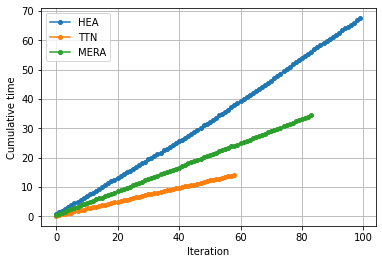

In [18]:
markersize = 4

plt.figure()
for (times, ansatz_name) in zip(times_opts, ansatz_list):
    plt.plot(np.cumsum(np.array(times)), "o-", label=ansatz_name, markersize=markersize)

plt.xlabel("Iteration")
plt.ylabel("Cumulative time")
plt.legend()
plt.grid()


Next, we'll look at how well each ansatz converged vs. iteration

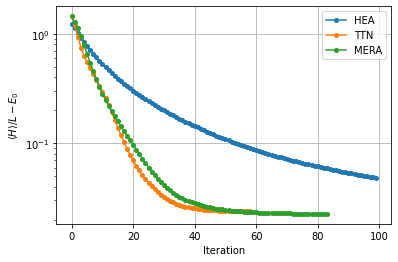

In [24]:
plt.figure()
for (objs, ansatz_name) in zip(objs_opts, ansatz_list):
    plt.semilogy(np.array(objs)/num_qubits-exact_E0, "o-", label=ansatz_name, markersize=markersize)
#plt.axhline(exact_E0/num_qubits, ls="--", color="k")
plt.xlabel("Iteration")
plt.ylabel("$\\langle H \\rangle / L - E_{0}$")
plt.legend()
plt.grid()

Finally, we'll look at how the error decreased over the computational time

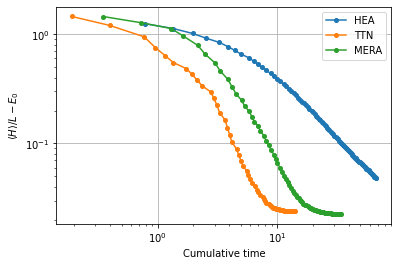

In [26]:
plt.figure()
for (times, objs, ansatz_name) in zip(times_opts, objs_opts, ansatz_list):
    plt.loglog(np.cumsum(np.array(times)), np.array(objs)/num_qubits-exact_E0, "o-", label=ansatz_name, markersize=markersize)

#plt.axhline(exact_E0/num_qubits, ls="--", color="k")
plt.xlabel("Cumulative time")
plt.ylabel("$\\langle H \\rangle / L - E_{0}$")
plt.legend()
plt.grid()